In [1]:
import json
import math
import os
import sys
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import statistics
import statsmodels.api as sm

warnings.filterwarnings('ignore')

In D:\Users\Marcelo\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In D:\Users\Marcelo\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In D:\Users\Marcelo\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In D:\Users\Marcelo\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In D:\Users\Marcelo\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classi

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer as Imputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, roc_curve, precision_recall_curve, confusion_matrix #, plot_confusion_matrix
from sklearn.metrics import accuracy_score, log_loss, f1_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [3]:
sys.path.append(os.path.join('..', 'src'))

In [4]:
import importlib
import s05_2_feature_engineering
# importlib.reload(model)
importlib.reload(s05_2_feature_engineering)
from s05_2_feature_engineering import build_polynomials, transform_label, treat_skewness

# Data capture

In [5]:
inputs = os.path.join('..', 'data', '03_processed')
models_reports = os.path.join('..', 'data', '04_models')
model_outputs = os.path.join('..', 'data', '05_model_output')
reports = os.path.join('..', 'data', '06_reporting')

X_train           = pd.read_csv(os.path.join(inputs, 'X_train.csv'), index_col='id')
X_test            = pd.read_csv(os.path.join(inputs, 'X_test.csv'), index_col='id')
X_train_onehot    = pd.read_csv(os.path.join(inputs, 'X_train_onehot.csv'), index_col='id')
X_test_onehot     = pd.read_csv(os.path.join(inputs, 'X_test_onehot.csv'), index_col='id')
y_train           = pd.read_csv(os.path.join(inputs, 'y_train.csv'), index_col='id')
y_test            = pd.read_csv(os.path.join(inputs, 'y_test.csv'), index_col='id')

# Machine Learning

In [6]:
# from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
# from xgboost.sklearn import XGBRegressor
from xgboost.sklearn import XGBClassifier

# Calculating final score with a test set

In [7]:
def get_transformations(X_set, y_set, cols,
               build_polynomals_method=False, 
                label_transformation_type=None, do_treat_skewness=False,
               imputation=None, scaler=None,
               ):
    X_set = X_set.copy()
#     if encoding == 'one-hot':
#         set_name = set_name+'_oh'
#     elif encoding == 'ordinal':
#         set_name = set_name
#     if treat_collinearity:
#         set_name = set_name+'_oh_nocol'
#     X_set = data_dict[set_name]
    print(cols)
    print(X_set.columns.to_list())
    X_set = X_set[cols]
#     X_set = X_set[['cycle']]
    
#     if build_polynomals_method: 
#         X_train_set = build_polynomials(X_set, ProjectParameters().numerical_cols, method = build_polynomals_method)
#     if label_transformation_type:
#         y_set = transform_label(y_set, label_transformation_type)
#     if do_treat_skewness:
#         X_set = treat_skewness(X_set, set_name)
        
    if scaler:
        X_set = scale.fit_transform(X_set)
        X_set = pd.DataFrame(X_set, columns = X_set.columns)
    if imputation:
        X_set.fillna(imputation)
    
    return X_set, y_set

In [8]:
columns = X_train.columns.to_list()

In [9]:
label_transformation_type = None

# X_train, y_train = get_transformations(
#         X_train, y_train, columns,
#         build_polynomals_method=None, do_treat_skewness=False,
#         imputation=None, scaler=None)

X_test, y_test = get_transformations(
        X_test, y_test, columns,
        build_polynomals_method=None, do_treat_skewness=False,
        imputation=None, scaler=None)

['gender_male', 'seniorcitizen', 'partner', 'dependents', 'tenure', 'phoneservice', 'multiplelines', 'internetservice', 'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport', 'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling', 'paymentmethod', 'monthlycharges', 'totalcharges', 'if_anomaly']
['gender_male', 'seniorcitizen', 'partner', 'dependents', 'tenure', 'phoneservice', 'multiplelines', 'internetservice', 'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport', 'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling', 'paymentmethod', 'monthlycharges', 'totalcharges', 'if_anomaly']


# load results
Capture best parameters of chosen model which were obtained during cross validation

In [10]:
def load_json_results(model_type):
    filepath = os.path.join(model_outputs, model_type+'.json')
    with open(filepath, 'r') as file:
        json_results = json.load(file)
    model = json_results[model_type]
#     model = json_results
    return model

# build model to apply on test set

In [11]:
def build_model(ml_model_type, X, y):
    ml_model = load_json_results(ml_model_type)

    if ml_model_type.startswith('tree_rf'):
        params = {}
        cols = ml_model['columns']
        for k,v in ml_model['best_params'].items():
            k = k[7:]
            params[k] = v

        model = RandomForestClassifier()

    elif ml_model_type.startswith('tree_xgb'):
        params = ml_model['best_params']
        cols = ml_model['columns']
        
        model = XGBClassifier()
        
        X = X[cols]

    for k,v in params.items(): 
        setattr(model, k, v)

    model.fit(X, y)
    
    return model, cols

In [12]:
# ['tree_xgb', 'tree_xgb_num', 'tree_xgb_numcyc', 'tree_xgb_numcyc_smote', 'tree_rf']
ml_model = 'tree_xgb'

model, columns = build_model(ml_model, X_train, y_train)
X_test = X_test[columns]
y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)[:, 1]

# calculate test score 
main metric: mean squared error for regression, f1_score for binary target

In [13]:
# print('mean squared error:', round(mean_squared_error(y_test, y_pred), 3))
# print('r2_score', round(r2_score(y_test, y_pred),3))
# print('mean_absolute_error', round(mean_absolute_error(y_test, y_pred),3))
print("\nCLASSIFICATION_REPORT:\n", classification_report(y_test, y_pred))
print('accuracy_score', round(accuracy_score(y_test, y_pred), 3))
print('log_loss', round(log_loss(y_test, y_pred_prob), 3))
print('f1_score', round(f1_score(y_test, y_pred, average='weighted'), 3))
#     plot_confusion_matrix(model, transformed_dicts['X_test'], y_test,
#                      cmap=plt.cm.Blues);


CLASSIFICATION_REPORT:
               precision    recall  f1-score   support

         0.0       0.83      0.91      0.87      1533
         1.0       0.67      0.50      0.58       580

    accuracy                           0.80      2113
   macro avg       0.75      0.71      0.72      2113
weighted avg       0.79      0.80      0.79      2113

accuracy_score 0.797
log_loss 0.433
f1_score 0.787


# sample prediction
predict first 10 entries

# rebuild model for entire dataset

In [14]:
X = X_train.copy().append(X_test)
y = y_train.copy().append(y_test)
# y.extend(y_test)

# ml_model = 'tree_randomforest'
ml_model = 'tree_xgb'
final_model = build_model(ml_model, X, y)

# save pickle of results

In [15]:
file = os.path.join(model_outputs, 'trained_model.pkl')
with open(file, 'wb') as f:
    pickle.dump(final_model, f)  

# compare estimated value with true value for sample

In [16]:
index_name = X.index.name
ordered_users = pd.DataFrame(list(zip(X.index, y_pred, y_test)), columns = [index_name, 'estimated', 'true_value']).set_index(index_name)
# ordered_users
ordered_users.tail(10).sort_values(by='true_value', ascending=True)

,estimated,true_value
id,,
7590-vhveg,0.0,y


# Decision making

# Sort entries
Retrieve IDs e and sort them by probability.

In [17]:
index_name = X_train.index.name
y_pred = y_pred_prob
ordered_users = pd.DataFrame(list(zip(X_test.index, y_pred, y_test['y'])), columns = [index_name, 'probabilidade', 'valor_verdadeiro']).set_index(index_name)
# ordered_users.sort_values(by='probabilidade', ascending=False, inplace=True)
ordered_users.head()

,probabilidade,valor_verdadeiro
id,,
8180-akmjv,0.486088,0.0
4298-oyifc,0.848711,0.0
5566-soezd,0.109491,0.0
9842-efsyy,0.226268,0.0
2272-wuspa,0.029800,0.0


Now let's see the number of observations from testset and how many of them are positive or negative.

In [18]:
users_total = len(ordered_users)
users_yes = len(ordered_users[ordered_users['valor_verdadeiro'] == 1])
users_no = users_total - users_yes
print('Size of test set:', users_total)
print('number of positive cases:', users_yes, 'ou {}% do total'.format(round(users_yes/users_total*100, 2)))
print('number of negative cases:', users_no, 'ou {}% do total'.format(round(users_no/users_total*100, 2)))

Size of test set: 2113
number of positive cases: 580 ou 27.45% do total
number of negative cases: 1533 ou 72.55% do total


# Análise de thresholds
Let's compare the probability thresholds for decision making. Assuming 1 for positive cases, and 0 for negative ones.

### Precision Recall Curve

TP=True Positives, FP=False Positives, TN=True Negatives, and FN=False Negatives:
* Precision is given by: $\frac{TP}{TP+FP}$
* Recall (sensitivity) is given by: $\frac{TP}{TP+FN}$

FP are those cases where the model mistakenly classifies negative cases as positive. While recall measures the proportion of correctly classified as positives from the positive population (focus on FN), precision measures the proportion of true positives from the cases classified as positives (focus on FP)

There are other metrics for binary classification. For instance, ROC curve (receiver operating characteristic) shows how much of a rise of TPR (True Positive Rate) also increses FPR (False Positive Rate). Despite the usefulness of that graphic, we believe that precision-recall curve is enough.

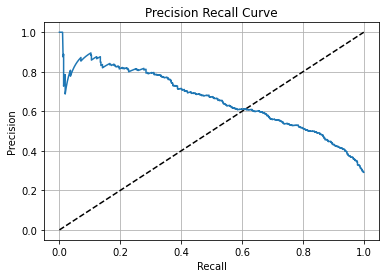

In [19]:
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(recalls, precisions)
plt.grid()
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision Recall Curve')
plt.show()

As we can see in this graphic, it is possible to increase recall withouth too much sacrifice in precision until the level of 0.95.

If we consider a threshold of 50%, we get a precision of 40% and reach 22% of cases of interest.

In [20]:
def print_thresholds(thres_list, thres=0.5):
    thres_index = np.where(thres_list>=thres)[0][0]
    print('threshold:', round(thres_list[thres_index],2))
    print('precision:', round(precisions[thres_index],2))
    print('recall:', round(recalls[thres_index],2))

In [21]:
print_thresholds(thresholds, thres=0.5)

threshold: 0.5
precision: 0.67
recall: 0.5


Let's reduce the threshold and see what happens

In [22]:
print_thresholds(thresholds, thres=0.4)

threshold: 0.4
precision: 0.61
recall: 0.59


Up until now, it seems that it makes sense to lower the threshold in order to reach a higher recall.

In [23]:
print_thresholds(thresholds, thres=0.3)

threshold: 0.3
precision: 0.56
recall: 0.7


In [24]:
print_thresholds(thresholds, thres=0.1)

threshold: 0.1
precision: 0.4
recall: 0.94


After reducing excessively the threshold, we might attain to cover all machine failures, but to the cost of a low precision. By assuring that all failures are prevented (no False Negative), we would be investing too much money on False Positives (by fixing machines which have low risk of failing). Depending on the costs, we risk having a lower ROI (Return on Investment).

Let's evaluate absolute values

### Build list of accumulated values

In [25]:
ordered_users['unique_prob'] = ~ordered_users.duplicated(subset = 'probabilidade', keep='last')

ordered_users['in_threshold'] = ordered_users[ (ordered_users['unique_prob'] == True) 
                                              & (ordered_users['probabilidade'].isin(thresholds)) ].probabilidade

unique_prob = ordered_users['unique_prob'].to_list()
in_threshold = ordered_users['in_threshold'].to_list()
ordered_users.drop(['in_threshold', 'unique_prob'], axis=1, inplace=True)

build list of cumulative values

In [26]:
cum_positive = ordered_users.valor_verdadeiro.cumsum().to_list()

cum_positive_filtered = []
cum_target_users = []
for i,val in enumerate(in_threshold):
    if not math.isnan(val):
        cum_value_pos = cum_positive[i]
        cum_positive_filtered.append(cum_value_pos)
        cum_target_users.append(i)
        
cum_positive_filtered = list(reversed(cum_positive_filtered))
cum_target_users = list(reversed(cum_target_users))

## Compare absolute numbers
Let's compare absolute numbers to see the real effect 

In [27]:
cum_positive_filtered.append(cum_positive_filtered[-1])
cum_target_users.append(cum_target_users[-1])

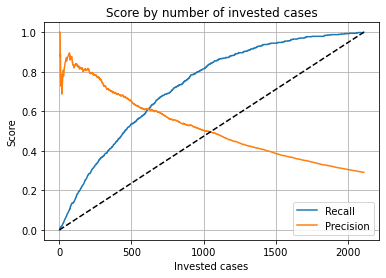

In [28]:
plt.plot(cum_target_users, recalls)
plt.plot(cum_target_users, precisions)
plt.plot([0, max(cum_target_users)], [0, 1], 'k--')
plt.grid()
plt.legend(labels  = ['Recall', 'Precision'])
plt.xlabel('Invested cases')
plt.ylabel('Score')
plt.title('Score by number of invested cases')
plt.show()

<!-- ### Compara resultados positivos com números absolutos em cada threshold
Note que essa curva é idêntica ao recall, mas é agora em número absolutos em vez de proporção. -->

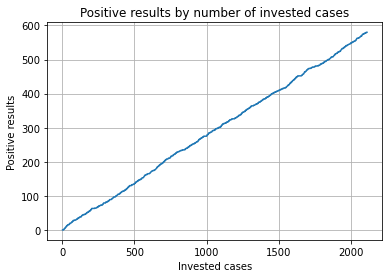

In [29]:
plt.plot(cum_target_users, cum_positive_filtered)
plt.grid()
plt.xlabel('Invested cases')
plt.ylabel('Positive results')
plt.title('Positive results by number of invested cases')
plt.show()

# Final thoughts

If we invested in only 8000 of users of higher probability to answer to campaign, we would achieve 3000 positive cases. But if we tried to increase that number to 4000 (1/3 de aumento!), we would need to double the investment, in other words, surpass 16000!

Therefore, I would suggest a threshold close to 0.1 (10%). With that, we get many true positives while avoiding a high cost that could reduce ROI, given the consideration that the marginal cost would be low.

Beyond that, the teams which are interested in evaluating the most relevant variables can consult feature importances results. 